In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

figsize = (14, 3.5)

# Language Recognition

## Language Recognition

**Let's consider the following problem:**

* Given a short piece of text (e.g. a sentence)
* We want to determine in which language it is written (English/French/Italian)

Some examples:

> The doctor, who was the family physician, saluted him, but he scarcely took any notice. **--> English**

> J'ai couru chez toi, je ne t'ai plus trouvée, tu sais la parole que je t'avais donnée, je la Bens. **--> French**

> Conosci tu qualche hossanieh poco scrupoloso che si possa comperare con un bel pugno d'oro? **--> Italian**

## A Look at the Data

**We can find the data for this problem in the `data` folder**

In [3]:
!ls data

SeoulBikeData.csv  lr_test.txt	lr_train.txt  real_estate.csv  weather.csv


* Specifically, we care about the `lr_train.txt` and `lr_test.txt` files
* Let's have a look at their content:

In [4]:
with open('data/lr_train.txt') as fp:
    lines = fp.readlines()[:4]
    print('\n'.join(lines))

The doctor, who was the family physician, saluted him, but he scarcely took any notice.@english

Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie.@french

"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop.@english

Ammantellato accuratamente, egli passeggiava innanzi e indietro, colla testa china sul petto, la fronte aggrottata e gli occhi accesi da una cupa fiamma.@italian



## Feature Extraction

**This is raw text data**

What if we want to deal with this using a DT?

* We need to find a _numeric encoding_
* ...But a one-hot encoding will not longer be enough

**The traditional approach in this situation consist in:**

* Applying algorithms to the data in order to extract numerical _features_
* Use the features as input for the linear model

**The task of finding good features is also known as _feature engineering_**

It is a critical step in classical Machine Learning

* Good features will lead to good results and vice-versa
* It can also be a challenging task!

The success of Deep Learning is partly due to the possibility to skip this step

## Loading the Data

**We will rely on a custom module**

...This is called `util.pyu` and is available in the `util` folder

In [5]:
!ls util

__init__.py  __pycache__  util.py


From the module, we call the `load_lr_data` function:

In [6]:
from util import util

text_train, lang_train = util.load_lr_data('data/lr_train.txt')
text_test, lang_test = util.load_lr_data('data/lr_test.txt')

for text, lang in zip(text_train[:3], lang_train[:3]):
    print(f'{text} --> {lang}')

The doctor, who was the family physician, saluted him, but he scarcely took any notice. --> english
Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie. --> french
"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop. --> english


## Feature Extraction in Practice

**We can build a function to process all pieces of text**

* For each piece of text, we will run simple algorithms and extract numeric features
* These features specifically are _not very good_
* Later, we will work to improve them!

We call the function for both our training and test data

In [12]:
import pandas as pd
import numpy as np
import unidecode
from sklearn.preprocessing import StandardScaler

# Here is a list of all separators found in the data
separators = ['(', '«', ',', '»', u"'", '+', '/', '°', ';', '?', '[', '_', ' ', '\n', '"', '&', '*', '.', ':', '\t', '!', ')', '-', 'º', ']', ]
separators_as_string = ''.join(separators)

def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    names = []
    # Loop over all pieces of text
    for cnt, lne in enumerate(text):
        # PREPARE A ROW FOR THE DATASET
        row = []
        # Obtain the list of words (this is useful to extract many features)
        words = [w.strip(separators_as_string) for w in lne.split()]
        words = [w for w in words if len(w) > 0]

        # EXTRACT FEATURES
        # F0: Number of words
        nwords = len(words)
        row.append(nwords)
        if cnt == 0: names.append('nwords')
        # F1: Number of characters per word
        row.append(len(lne) / nwords)
        if cnt == 0: names.append('ncpw')
        # F2: Get number of vowels
        # NOTE: "lower()" makes the string lower case
        nvowels = len([c for c in lne if c.lower() in ('a', 'e', 'i', 'o', 'u', 'y')])
        row.append(nvowels)
        if cnt == 0: names.append('nvowels')
        # F3: Get the number of words starting with "p"
        nstartp = len([w for w in words if w[0] == 'p'])
        row.append(nstartp)
        if cnt == 0: names.append('nstartp')
        # F4: Get number of occurrences of either "cookie" or "wookie"
        ncwookie = len([w for w in words if w in ['cookie', 'wookie']])
        row.append(ncwookie)
        if cnt == 0: names.append('ncwookie')
        
        # APPEND THE ROW
        res.append(row)
    # Return the result
    return pd.DataFrame(columns=names, data= res)


x_train = extract_features(text_train)
x_test = extract_features(text_test)

## Feature Extraction in Practice

**We can now have a look at the result**

In [13]:
for text in text_train[:5]: print(text)
display(x_train.head())

The doctor, who was the family physician, saluted him, but he scarcely took any notice.
Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie.
"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop.
Ammantellato accuratamente, egli passeggiava innanzi e indietro, colla testa china sul petto, la fronte aggrottata e gli occhi accesi da una cupa fiamma.
--Tu mi chiedevi il perchè ti seppellii in quest'inferno, diss'egli, calcando su ogni parola.


,nwords,ncpw,nvowels,nstartp,ncwookie
0,15,5.800000,29,1,0
1,29,6.344828,60,1,0
2,20,5.500000,36,0,0
3,23,6.652174,57,2,0
4,14,6.642857,31,2,0


* We now have a usable dataset!
* Just don't count on the initial feature to be any good ;-)

## Language Recognition using DTs

**We now need to take care of the targets**

* We have three classes, encoded as string
* ...But that's not a problem for DTs!

In [14]:
lang_train = pd.Series(lang_train).astype('category')
lang_test = pd.Series(lang_test).astype('category')

* With Logistic Regression this would _not_ be enough
  - ...Since it would introduce an implicit ordering over the classes
* But Decision Trees do not care about that!

## Language Recognition using DTs

**We will train a Random Forest model**

...And we will use grid search + cross-validation to tune the depth

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfm = RandomForestClassifier(n_estimators=100)
param_grid = {'max_depth': np.arange(6, 14, 2)}
rfm_cv = GridSearchCV(rfm, param_grid=param_grid)
rfm_cv.fit(x_train, lang_train);

print(f'Best results with: {rfm_cv.best_params_}')

Best results with: {'max_depth': 12}


## Evaluation

**We can now obtain the predictions and evaluate the model (on the test set)**

Accuracy on the test set: 0.76


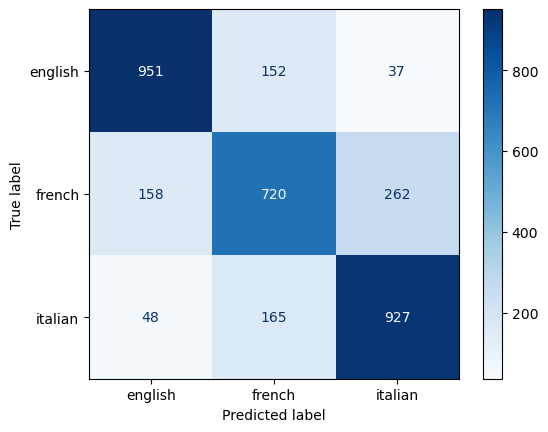

In [16]:
y_pred_ts = rfm_cv.predict(x_test)
ConfusionMatrixDisplay.from_estimator(rfm_cv, x_test, lang_test, display_labels=lang_test.cat.categories, cmap='Blues');
print(f'Accuracy on the test set: {accuracy_score(lang_test, y_pred_ts):.3}')

* The matrix tells us _how many_ and _which_ mistakes we making

## Attribute Importance

**We can use importances to assess the effectiveness of our features**

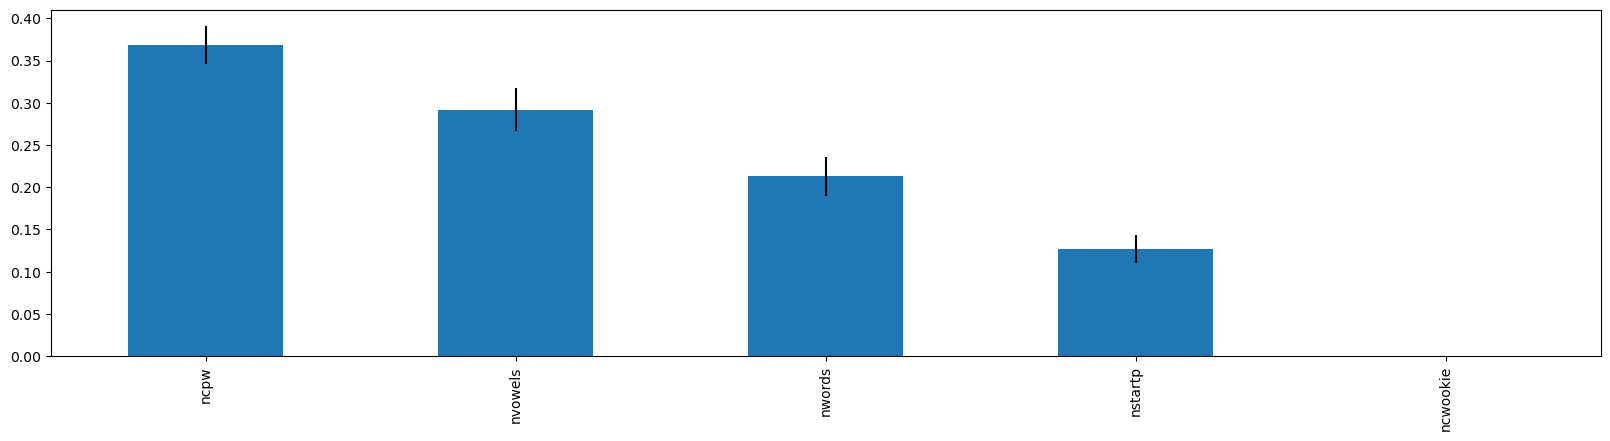

In [17]:
rf_is_mean = rfm_cv.best_estimator_.feature_importances_
rf_is_std = np.std([t.feature_importances_ for t in rfm_cv.best_estimator_.estimators_], axis=0)
sorted_idx = np.argsort(-rf_is_mean)
dt_is = pd.Series(data=rf_is_mean[sorted_idx], index=x_train.columns[sorted_idx])
dt_is.plot.bar(figsize=figsize, yerr=rf_is_std);

# Let's Put Everything Together

## Let's Put Everything Together

**Finally, we can put everything together**

We can improve our model by:

* Extracting features
* Training a model
* Checking _which kind of mistakes we are making_
* Checking _which features are actually useful_

...And the using the collected information to devise new features!

**You can find the process for a whole iteration in a single cell, for convenience:** 

Best parameters: {'max_depth': 12}
Accuracy on the test set: 0.994


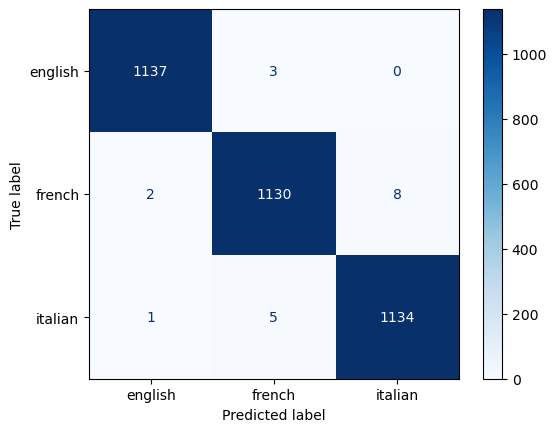

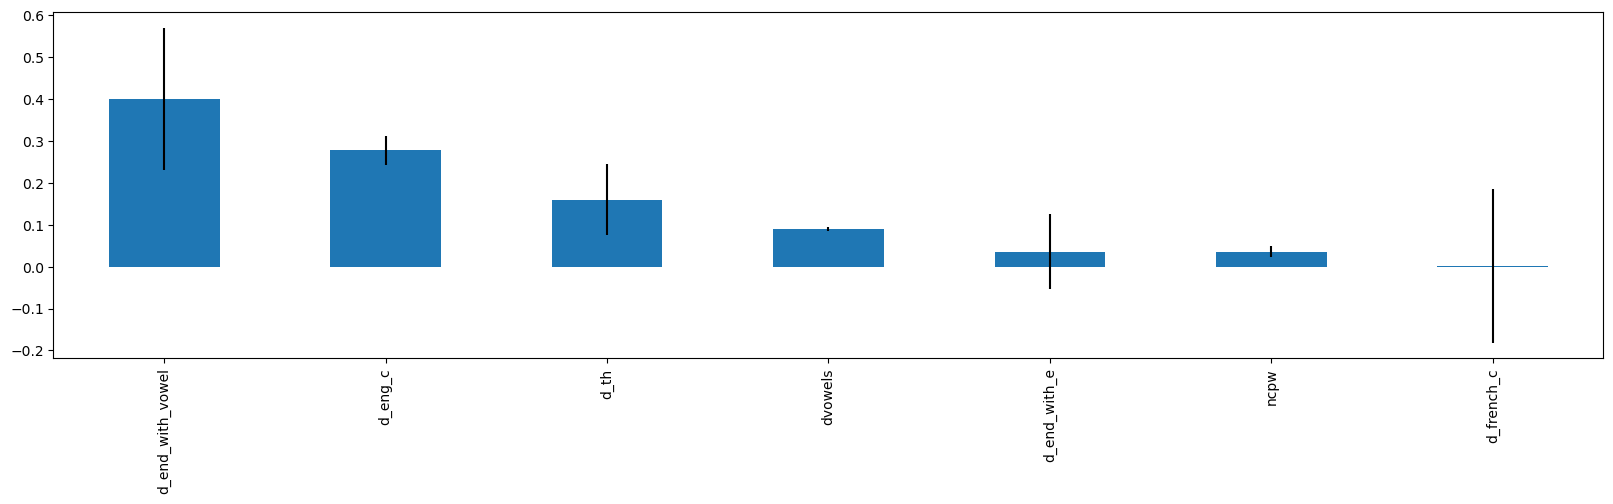

In [20]:
def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    names = []
    # Loop over all pieces of text
    for cnt, lne in enumerate(text):
        # PREPARE A ROW FOR THE DATASET
        row = []
        # Obtain the list of words (this is useful to extract many features)
        words = [w.strip(separators_as_string) for w in lne.split()]
        words = [w for w in words if len(w) > 0]

        # EXTRACT FEATURES
        nwords = len(words)
        # F0: Number of words
        d_th = lne.count('th')
        d_th / len(lne)
        row.append(d_th)
        if cnt == 0: names.append('d_th')
        # F1: Number of characters per word
        row.append(len(lne) / nwords)
        if cnt == 0: names.append('ncpw')
        # F2: Get number of vowels
        # NOTE: "lower()" makes the string lower case
        dvowels = len([c for c in lne if c.lower() in ('a', 'e', 'i', 'o', 'u', 'y')])
        dvowels /= len(lne)
        row.append(dvowels)
        if cnt == 0: names.append('dvowels')
        # F3: Get the number of french characters
        d_french_c = len([c for c in lne if c == 'ç'])
        d_french_c /= len(lne)
        row.append(d_french_c)
        if cnt == 0: names.append('d_french_c')
        # F4: number of words that end with a vowel
        d_end_with_vowel = len([w for w in words
                                if w[-1].lower() in ('a', 'e', 'i', 'o', 'u',
                                                     'à', 'è', 'é', 'ì', 'ò', 'ù')])
        d_end_with_vowel /= len(words)
        row.append(d_end_with_vowel)
        if cnt == 0: names.append('d_end_with_vowel')
        # 
        d_end_with_e = len([w for w in words
                        if w[-1].lower() in ('e')])
        d_end_with_e /= len(words)
        row.append(d_end_with_e)
        if cnt == 0: names.append('d_end_with_e')
        # 
        d_eng_c = len([c for c in lne if c in ('k', 'w', 'h')])
        d_eng_c /= len(lne)
        row.append(d_eng_c)
        if cnt == 0: names.append('d_eng_c')
        
        # APPEND THE ROW
        res.append(row)
    # Return the result
    return pd.DataFrame(columns=names, data= res)


x_train = extract_features(text_train)
x_test = extract_features(text_test)

# Train a model and calibrate the reguralizer weight
rfm = RandomForestClassifier(n_estimators=100)
param_grid = {'max_depth': np.arange(6, 14, 2)}
rfm_cv = GridSearchCV(rfm, param_grid=param_grid)
rfm_cv.fit(x_train, lang_train);
print(f'Best parameters: {rfm_cv.best_params_}')

# Evaluate accuracy
y_pred_ts = rfm_cv.predict(x_test)
print(f'Accuracy on the test set: {accuracy_score(lang_test, y_pred_ts):.3}')

# Check the confusion matrix
ConfusionMatrixDisplay.from_estimator(rfm_cv, x_test, lang_test, display_labels=lang_test.cat.categories, cmap='Blues');

# Plot attribute importances
rf_is_mean = rfm_cv.best_estimator_.feature_importances_
rf_is_std = np.std([t.feature_importances_ for t in rfm_cv.best_estimator_.estimators_], axis=0)
sorted_idx = np.argsort(-rf_is_mean)
dt_is = pd.Series(data=rf_is_mean[sorted_idx], index=x_train.columns[sorted_idx])
plt.figure(figsize=figsize)
dt_is.plot.bar(figsize=figsize, yerr=rf_is_std);